<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/16feb_superdarn_nn_pwr0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from datetime import datetime, timedelta
import random

In [ ]:
class DataLoader:
    def __init__(self,
                 datapath,
                 shuffle=True):
        self.shuffle = shuffle
        self.data = {}

        for root, _, files in os.walk(datapath):
            for name in files:
                filename = name.split('.')
                self.data[filename[0] + filename[1]] = np.load(os.path.join(root, name))

    def __call__(self):
        keys = list(self.data.keys())
        if self.shuffle:
            random.shuffle(keys)
        # итерация по ключам в словаре self.data
        for key in keys:
            # если маска целевого значения пустая, то пропускаем пример
            if np.all(self.data[key][:,:,-1,:,:] == 0.):
                continue
            seq = self.__getSequence(key)
            arrays = []
            badCount = 0
            # итерация по историческим данным
            for item in seq:
                # некоторые исторические данные могут отсутствовать
                try:
                    if np.all(self.data[item][:,:,-1,:,:] == 0.):
                        badCount += 1
                    arrays.append(self.data[item])
                except KeyError:
                    # print(f'No key: {item}')
                    badCount += 1
                    arrays.append(np.zeros_like(self.data[key]))
            # если пропусков в данных больше чем 10%, то пропускаем пример
            # print(f'Bad count: {badCount}')
            if badCount / len(arrays) > 0.1:
                continue
            else:
                x = np.concatenate(arrays, axis=1)
                y = self.data[key]
                # for beam in range(16):
                #     yield x[:,:,:,beam,0], y[:,:,:-1,beam,0]
                yield x[:,:,0:1,0,0], y[:,:,0:1,0,0]
    
    def __getSequence(self, key):
        keyDT = datetime.strptime(key, '%Y%m%d%H%M')
        # список массивов периодов за неделю до целевого массива
        weekBefore = []
        for i in range(24*7, 0, -2):
            hoursBefore = (keyDT-timedelta(hours=i)).strftime('%Y%m%d%H%M')
            weekBefore.append(hoursBefore)
        return weekBefore

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
# генератор
def get_generator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))
    noise = tf.keras.layers.Input(shape=(70, 60, 1))
    concat = tf.keras.layers.Concatenate(axis=2)([history, noise])
    reshape = tf.keras.layers.Reshape(target_shape=(70, 5100//60, 60, 1))(concat)
    permute = tf.keras.layers.Permute((2,1,3,4))(reshape)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=8,
                                  padding='same',
                                  activation='relu')(permute)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=8,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=4,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=4,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=2,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=2,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 1, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=1,
                                  kernel_size=1,
                                  padding='same',
                                  activation='linear')(pool)

    output = tf.keras.layers.Reshape(target_shape=(70, 60, 1))(conv)
    generator = tf.keras.models.Model([history, noise], output, name='generator')

    return generator

# дискриминатор
def get_discriminator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))
    target = tf.keras.layers.Input(shape=(70, 60, 1))
    concat = tf.keras.layers.Concatenate(axis=2)([history, target])
    reshape = tf.keras.layers.Reshape(target_shape=(70, 5100//60, 60, 1))(concat)
    permute = tf.keras.layers.Permute((2,1,3,4))(reshape)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=8,
                                  padding='same',
                                  activation='relu')(permute)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=8,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=4,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=4,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=2,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=64,
                                  kernel_size=2,
                                  padding='same',
                                  activation='relu')(pool)
    pool = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1))(conv)

    conv = tf.keras.layers.Conv3D(filters=1,
                                  kernel_size=1,
                                  padding='same',
                                  activation='relu')(pool)
                
    flatten = tf.keras.layers.Flatten()(conv)
    dense = tf.keras.layers.Dense(60, activation='sigmoid')(flatten)
    
    discriminator = tf.keras.models.Model([history, target], dense, name='discriminator')
    return discriminator

In [ ]:
class RadarGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # выход генератора
            generated = tf.cast(self.generator([x, tf.random.uniform(shape=(y_shape[0], y_shape[1], y_shape[2], 1))]), dtype=tf.dtypes.float64)
            
            with tf.GradientTape() as tape:
                real = self.discriminator([x, y])
                fake = self.discriminator([x, generated])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x, mixed])

                loss_on_mixed = self.loss_fn(real, predictions)
                
                # TODO: собрать все варианты (real, fake, mixed) в один батч?

                d_loss = loss_on_real + loss_on_fake
                # + loss_on_mixed


            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:
                generated = self.generator([x, tf.random.uniform(shape=(y_shape[0], y_shape[1], y_shape[2], 1))])
                discriminated = self.discriminator([x, generated])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=keras.models.load_model('drive/MyDrive/radargan_discriminator.hdf5'), generator=keras.models.load_model('drive/MyDrive/radargan_generator.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [ ]:
batch_size = 1

train_loader = DataLoader('drive/MyDrive/2002-val')
# val_loader = DataLoader('drive/MyDrive/2002-val')

train_dataset = tf.data.Dataset.from_generator(train_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)
# val_dataset = tf.data.Dataset.from_generator(val_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=10)

Epoch 1/10
466/466 [==============================] - 745s 2s/step - g_loss: 0.6932 - d_loss: 1.3863 - g_mae: 1.4002
Epoch 2/10
466/466 [==============================] - 726s 2s/step - g_loss: 0.6931 - d_loss: 1.3863 - g_mae: 1.4482
Epoch 3/10
 40/466 [=>............................] - ETA: 11:06 - g_loss: 0.6931 - d_loss: 1.3863 - g_mae: 1.7925

KeyboardInterrupt: ignored

In [ ]:
radar_gan.generator.save('drive/MyDrive/radargan_generator_new.hdf5')
radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_new.hdf5')

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, channel=0, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(4, n_examples)

    for i in range(n_examples):
        x, y = dataset.next()
        fake = radar_gan.generator.predict([x, np.random.rand(y.shape[0], y.shape[1], y.shape[2], 1)])
        d_real = radar_gan.discriminator.predict([x, y])
        d_fake = radar_gan.discriminator.predict([x, fake])

        axis[0, i].imshow(y[0, :, :, channel])
        axis[0, i].set_title("R")

        axis[1, i].imshow(fake[0, :, :, channel])
        axis[1, i].set_title("G")

        axis[2, i].imshow((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G")

        axis[3, i].hist((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G distr")

    plt.show()
    plt.hist

        # axis[3, i].imshow(d_fake[:, :])
        # axis[3, i].set_title("Discriminated fake data")

1/1 [==============================] - 0s 25ms/step


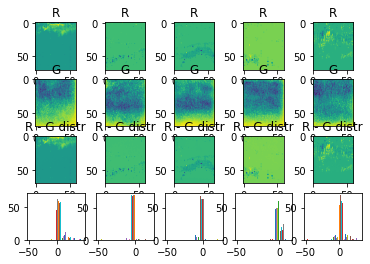

In [ ]:
plot_output(radar_gan, train_dataset)

In [ ]:
for x, y in train_dataset:
    fake = radar_gan.generator.predict([x, np.random.rand(y.shape[0], y.shape[1], y.shape[2], 7)])
    print('real: ', radar_gan.discriminator.predict([x, y]))
    print('fake: ', radar_gan.discriminator.predict([x, fake]))
    break

In [ ]:
for x, y in train_dataset:
    print(x.shape, y.shape)
    break

(1, 70, 5040, 1) (1, 70, 60, 1)
